In [102]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
import pandas as pd

In [103]:

def export_data(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, header=False, index=False)
    print(f"Données exportées dans {filename}")

def process_dataset_from_sklearn(dataset_name, n_bits, method="uniform"):

    def uniform_quantize(data, n_bits):
        # 2 bits = 4 niveaux (00, 01, 10, 11)
        n_levels = 2**n_bits
        
        # Normaliser les données entre 0 et n_levels-1
        min_vals = np.min(data, axis=0)
        max_vals = np.max(data, axis=0)
        normalized = (data - min_vals) / (max_vals - min_vals) * (n_levels-1)
        
        # Quantifier en valeurs entières de 0 à n_levels-1
        quantized = np.round(normalized).astype(int)
        quantized = np.clip(quantized, 0, n_levels-1)
        
        return quantized

    def non_uniform_quantize(data, n_bits):
        n_levels = 2 ** n_bits
        
        # Calcul des quantiles pour les limites de chaque niveau
        quantiles = np.linspace(0, 1, n_levels + 1)
        thresholds = np.percentile(data, quantiles * 100)
        
        # Fonction de quantification : on affecte à chaque valeur de `data` un niveau
        quantized_data = np.digitize(data, thresholds[1:], right=True)
        
        return quantized_data


    def freedman_quantize(data, n_bits):
       
        n_features = data.shape[1]
        quantized = np.zeros_like(data).astype(int)
        for i in range(n_features):
            quantized[:, i] = freedman_quantize_column(data[:, i])

        return quantized

    def freedman_quantize_column(data):
        n = len(data)
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        bin_width = 2 * iqr * (n ** (-1/3))
        
        bins = np.arange(data.min(), data.max() + bin_width, bin_width)
        quantized = np.digitize(data, bins, right=True).astype(int)
        return quantized

    if method == "uniform":
        quantize = uniform_quantize
        output_file = f"data/{dataset_name}_uni_{n_bits}bits.csv"
    elif method == "non_uniform":
        quantize = non_uniform_quantize
        output_file = f"data/{dataset_name}_non_uni_{n_bits}bits.csv"
    elif method == "freedman":
        quantize = freedman_quantize
        output_file = f"data/{dataset_name}_freedman.csv"
    elif method == "none":
        quantize = lambda x, y: x
        output_file = f"data/{dataset_name}_original.csv"
    else:
        raise ValueError("Method must be 'uniform', 'non_uniform' or 'freedman'")

    
    if dataset_name not in ["iris", "wine"]:
        raise ValueError("Dataset must be 'iris' or 'wine'")


    data = load_iris() if dataset_name == "iris" else load_wine()

    
    print(f"Dataset : {dataset_name}")
    print(f"Number of samples: {data.data.shape[0]}")
    print(f"Number of features: {data.data.shape[1]}")
    print(f"Number of classes: {len(np.unique(data.target))}")
    print("---")
    
    X = data.data
    X_quantized = quantize(X, n_bits)
    
    # Combine features and target into one array before exporting
    full_data = np.column_stack((X_quantized, data.target))
    export_data(full_data, output_file)




In [104]:

process_dataset_from_sklearn("iris", 4, method="freedman")

Dataset : iris
Number of samples: 150
Number of features: 4
Number of classes: 3
---
[2 2 1 1 2 3 1 2 1 2 3 2 2 0 4 3 3 2 3 2 3 2 1 2 2 2 2 2 2 1 2 3 2 3 2 2 3
 2 1 2 2 1 1 2 2 2 2 1 3 2 6 5 6 3 5 3 5 2 5 2 2 4 4 4 3 5 3 4 4 3 4 4 5 4
 5 5 6 5 4 3 3 3 4 4 3 4 5 5 3 3 3 4 4 2 3 3 3 4 2 3 5 4 6 5 5 7 2 7 5 6 5
 5 6 3 4 5 5 7 7 4 6 3 7 5 5 6 4 4 5 6 7 8 5 5 4 7 5 5 4 6 5 6 4 6 5 5 5 5
 4 4]
[ 8  6  7  6  9 11  8  8  5  6 10  8  6  6 11 13 11  8 10 10  8 10  9  7
  8  6  8  8  8  7  6  8 12 12  6  7  8  9  6  8  8  2  7  8 10  6 10  7
 10  7  7  7  6  2  5  5  7  3  5  4  0  6  2  5  5  6  6  4  2  3  7  5
  3  5  5  6  5  6  5  4  3  3  4  4  6  8  6  2  6  3  4  6  4  2  4  6
  5  5  3  5  7  4  6  5  6  6  3  5  3  9  7  4  6  3  5  7  6 10  4  2
  7  5  5  4  7  7  5  6  5  6  5 10  5  5  4  6  8  6  6  6  6  6  4  7
  7  6  3  6  8  6]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 2 3 3 2 3 3 3 2 3 3 3 3 3 3 3 3 3
 

In [105]:
# process_dataset_from_sklearn("wine", 4)

In [106]:
import pandas as pd
def calculate_column_mean(csv_file, column_index):
    """
    Calculate mean of a specific column from a CSV file
    
    Args:
        csv_file (str): Path to the CSV file
        column_index (int): Index of the column to calculate mean for
        
    Returns:
        float: Mean value of the specified column
    """
    # Read CSV into DataFrame without headers
    df = pd.read_csv(csv_file, header=None)
    
    # Calculate mean of specified column
    column_mean = df[column_index].mean()
    
    return column_mean




In [107]:
# acc_wine_mean_4 = calculate_column_mean("logs/wine_4bits_4_64.csv", 0)
# print(f"Mean accuracy wine depth 4 : {acc_wine_mean_4}")
# acc_wine_mean_3 = calculate_column_mean("logs/wine_4bits_3_64.csv", 0)
# print(f"Mean accuracy wine depth 3 : {acc_wine_mean_3}")
# acc_wine_mean_2 = calculate_column_mean("logs/wine_4bits_2_64.csv", 0)
# print(f"Mean accuracy wine depth 2 : {acc_wine_mean_2}")
# # acc_wine_mean_1 = calculate_column_mean("logs/wine_4bits_1_64.csv", 0)
# # print(f"Mean accuracy wine depth 1 : {acc_wine_mean_1}")
# time_wine_mean_4 = calculate_column_mean("logs/wine_4bits_4_64.csv", 1)
# print(f"Mean time wine depth 4: {time_wine_mean_4}")
# time_wine_mean_3 = calculate_column_mean("logs/wine_4bits_3_64.csv", 1)
# print(f"Mean time wine depth 3 : {time_wine_mean_3}")
# time_wine_mean_2 = calculate_column_mean("logs/wine_4bits_2_64.csv", 1)
# print(f"Mean time wine depth 2 : {time_wine_mean_2}")
# # acc_wine_mean_1 = calculate_column_mean("logs/wine_4bits_1_64.csv", 0)
# # print(f"Mean accuracy wine depth 1 : {acc_wine_mean_1}")

In [108]:
acc_iris_mean_4 = calculate_column_mean("logs/iris_4bits_4_64.csv", 0)
print(f"Mean accuracy iris depth 4 : {acc_iris_mean_4}")
acc_iris_mean_3 = calculate_column_mean("logs/iris_4bits_3_64.csv", 0)
print(f"Mean accuracy iris depth 3 : {acc_iris_mean_3}")
# acc_iris_mean_2 = calculate_column_mean("logs/iris_4bits_2_64.csv", 0)
# print(f"Mean accuracy iris depth 2 : {acc_iris_mean_2}")
# acc_iris_mean_1 = calculate_column_mean("logs/iris_4bits_1_64.csv", 0)
# print(f"Mean accuracy iris depth 1 : {acc_iris_mean_1}")
time_iris_mean_4 = calculate_column_mean("logs/iris_4bits_4_64.csv", 1)
print(f"Mean time iris depth 4: {time_iris_mean_4}")
time_iris_mean_3 = calculate_column_mean("logs/iris_4bits_3_64.csv", 1)
print(f"Mean time iris depth 3 : {time_iris_mean_3}")
# time_iris_mean_2 = calculate_column_mean("logs/iris_4bits_2_64.csv", 1)
# print(f"Mean time iris depth 2 : {time_iris_mean_2}")
# acc_iris_mean_1 = calculate_column_mean("logs/iris_4bits_1_64.csv", 0)
# print(f"Mean accuracy iris depth 1 : {acc_iris_mean_1}")

Mean accuracy iris depth 4 : 0.8666666666666666
Mean accuracy iris depth 3 : 0.8333333333333334
Mean time iris depth 4: 2292.4217399409
Mean time iris depth 3 : 2224.951069844


/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_43403/582839107.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(depth[2:], accuracy_private_wine[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")
/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_43403/582839107.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(depth[2:], accuracy_private_iris[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")


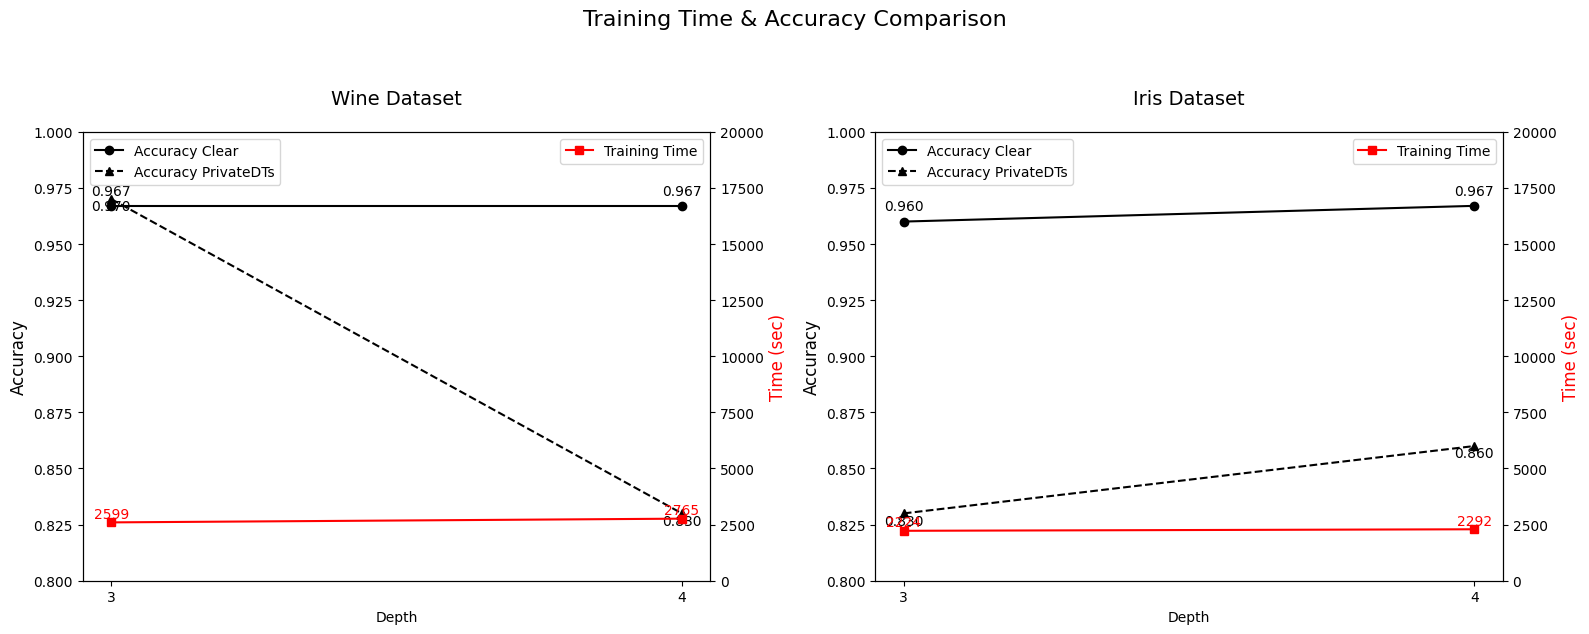

In [109]:
import matplotlib.pyplot as plt

# Données pour reproduire le graphique
depth = [1, 2, 3, 4]  # Profondeur
accuracy_clear_wine = [None, None, 0.967, 0.967]
accuracy_private_wine = [None, None, 0.97, 0.83]
training_time_wine = [None, None, 2599, 2765]

accuracy_clear_iris = [None, None, 0.960, 0.967]
accuracy_private_iris = [None, None, 0.83, 0.86]
training_time_iris = [None, None, 2224, 2292]

# Créer deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Premier graphique pour Wine
ax1_twin = ax1.twinx()
ax1.set_xlabel("Depth")
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_ylim(0.8, 1.0)
ax1.set_xticks(depth)
ax1.plot(depth[2:], accuracy_clear_wine[2:], 'o-', label="Accuracy Clear", color='black')
ax1.plot(depth[2:], accuracy_private_wine[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")

# Ajouter les valeurs sur les points pour Wine
for i in range(2, len(depth)):
    ax1.text(depth[i], accuracy_clear_wine[i] + 0.005, f"{accuracy_clear_wine[i]:.3f}", ha='center')
    ax1.text(depth[i], accuracy_private_wine[i] - 0.005, f"{accuracy_private_wine[i]:.3f}", ha='center')

ax1_twin.set_ylabel("Time (sec)", fontsize=12, color="red")
ax1_twin.set_ylim(0, 20000)
ax1_twin.plot(depth[2:], training_time_wine[2:], 's-', color='red', label="Training Time")

# Ajouter les valeurs pour les temps (Wine)
for i in range(2, len(depth)):
    ax1_twin.text(depth[i], training_time_wine[i] + 200, f"{training_time_wine[i]}", color="red", ha='center')

# Deuxième graphique pour Iris
ax2_twin = ax2.twinx()
ax2.set_xlabel("Depth")
ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_ylim(0.8, 1.0)
ax2.set_xticks(depth)
ax2.plot(depth[2:], accuracy_clear_iris[2:], 'o-', label="Accuracy Clear", color='black')
ax2.plot(depth[2:], accuracy_private_iris[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")

# Ajouter les valeurs sur les points pour Iris
for i in range(2, len(depth)):
    ax2.text(depth[i], accuracy_clear_iris[i] + 0.005, f"{accuracy_clear_iris[i]:.3f}", ha='center')
    ax2.text(depth[i], accuracy_private_iris[i] - 0.005, f"{accuracy_private_iris[i]:.3f}", ha='center')

ax2_twin.set_ylabel("Time (sec)", fontsize=12, color="red")
ax2_twin.set_ylim(0, 20000)
ax2_twin.plot(depth[2:], training_time_iris[2:], 's-', color='red', label="Training Time")

# Ajouter les valeurs pour les temps (Iris)
for i in range(2, len(depth)):
    ax2_twin.text(depth[i], training_time_iris[i] + 200, f"{training_time_iris[i]}", color="red", ha='center')

# Titres et légendes
ax1.set_title("Wine Dataset", fontsize=14, pad=20)
ax2.set_title("Iris Dataset", fontsize=14, pad=20)

ax1.legend(loc="upper left")
ax1_twin.legend(loc="upper right")
ax2.legend(loc="upper left")
ax2_twin.legend(loc="upper right")

fig.suptitle("Training Time & Accuracy Comparison", fontsize=16, y=1.05)
plt.tight_layout()


plt.show()